In [1]:
import numpy as np
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from tensorflow.keras.utils import Sequence
from random import shuffle
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import albumentations as A

In [2]:
tf.compat.v1.disable_eager_execution()

In [19]:
type1_txt = '/home/b170007ec/Programs/Cervix Cancer/good_files1.txt'
type2_txt = '/home/b170007ec/Programs/Cervix Cancer/files2good.txt'
type3_txt = '/home/b170007ec/Programs/Cervix Cancer/good_files3.txt'
img_dirs = []
labels = []
for class_,txt in enumerate([type1_txt,type2_txt,type3_txt]):
    for i,dir_ in enumerate(pickle.load(open(txt,'rb'))):
        dir_ = dir_.split('/')
        dir_[0] = '/home'
        dir_[1] = 'b170007ec'
        dir_.insert(4,'train')
        if 'additional' in dir_[-3].split('_'):
            dir_.remove(dir_[-2])
        else:
            dir_.remove(dir_[-3])
        dir_ = '/'.join(dir_)
        img_dirs.append(dir_)
    labels = labels + [class_]*(i+1)
#print(img_dirs)

In [20]:
#parameters
INPUT_SIZE = 512
BATCH_SIZE = 4
OUTPUT_SIZE = 64
STRIDE = 2
VALID_SPLIT = .1
EPOCHS = 40

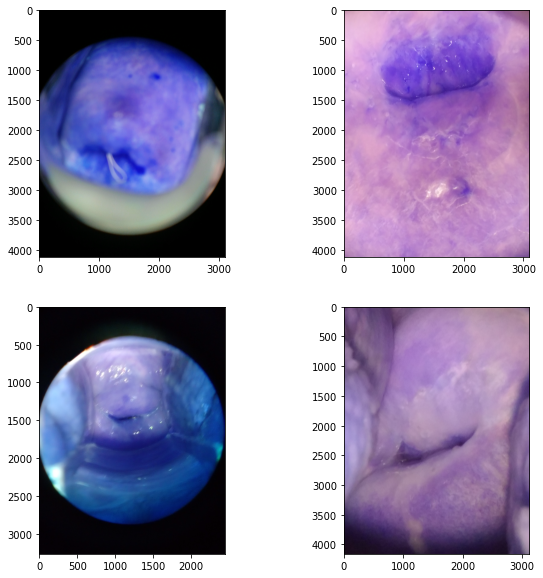

In [21]:
#random viz
def ran_viz():
    images = []
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    images = random.choices(img_dirs,k=4)
    for i,img in enumerate(images):
        ax[i//2][i%2].imshow(cv2.imread(img))
ran_viz()

In [22]:
#add noise
def add_noise(image,prob):

    def sp_noise(image, prob):
        '''
        Add salt and pepper noise to image
        prob: Probability of the noise
        '''
        output = image.copy()
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image
    def noisy(image):
        row,col,ch= image.shape
        mean = 0
        var = 0.2
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    return sp_noise(image,prob),noisy(image)
def image_blackout(image,x=None,y=None):
    image_ = image.copy()
    if x==None and y==None:
        h,w,c = image.shape
        x = random.randint(64,h-64)
        y = random.randint(64,w-64)
    crop = image[x-64:x+64,y-64:y+64]
    image_[x-64:x+64,y-64:y+64] = 0
    return image_,crop
def aug(max_angle=90):
    a = A.Compose([A.Rotate(limit = max_angle,p=1)])
    return a
#generator
class Generator(Sequence):
    def __init__(self,img_dirs,batch_size,input_size,is_train = True):
        self.img_dirs = img_dirs
        self.batch_size = batch_size
        self.input_size = input_size
        self.is_train = is_train
        if self.is_train:
            self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.img_dirs)/float(self.batch_size)))
    def on_epoch_end(self):
        if self.is_train:
            shuffle(self.img_dirs) 
    def __getitem__(self,idx):
        train_x = self.img_dirs[self.batch_size*idx:self.batch_size*(idx+1)]
        return self.generate(train_x)
    def generate(self,train_x):
        X = []
        Y = []
        for i,img in enumerate(train_x):
            image = cv2.imread(img)
            image = cv2.resize(image,(self.input_size,self.input_size))
            if self.is_train:
                x,y = image_blackout(image)
                X.append(x/255)
                Y.append(y/255)
                data = {'image':image}
                image = aug()(**data)
                image = image['image']
                x,y = image_blackout(image)
                X.append(x/255)
                Y.append(y/255)                
            else:
                x,y = image_blackout(image,120,120)
                X.append(x/255)
                Y.append(y/255)
        return np.asarray(X), np.asarray(Y)
    

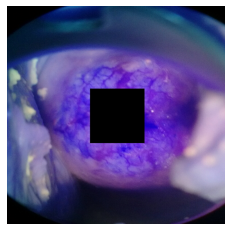

(128, 128, 3)


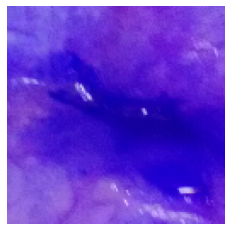

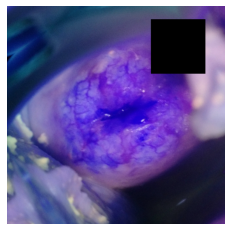

(128, 128, 3)


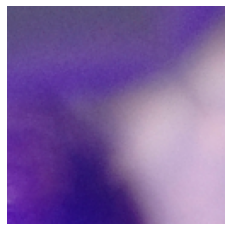

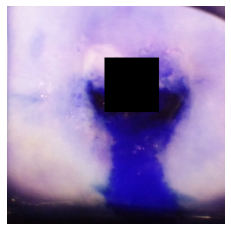

(128, 128, 3)


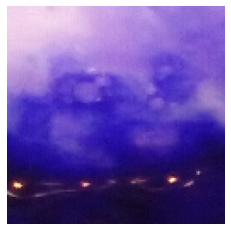

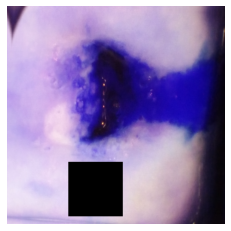

(128, 128, 3)


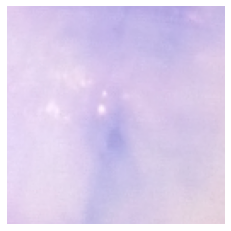

In [24]:
#testing generator
def test(data,i):
    gen = Generator(img_dirs,batch_size = 2,input_size=INPUT_SIZE)
    X,Y = gen.__getitem__(i)
    for x,y in zip(X,Y):
        plt.imshow(x)
        plt.axis("off")
        plt.savefig("Input.png")
        plt.show()
        plt.imshow(y)
        
        
        
        plt.axis("off")
        plt.savefig("Output.png")
        print(y.shape)
        plt.show()
test(data,3)

In [51]:
#efficientnet encoder
encoder = efn.EfficientNetB4(include_top=False, weights = 'imagenet', input_shape = (INPUT_SIZE,INPUT_SIZE,3))

In [52]:
#encoder summary
encoder.summary();

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [53]:
#supporting blocks
def up_image(input_1,c=None):
    x = UpSampling2D((2,2))(input_1)
    x_ = Conv2D(c//4,(1,1),kernel_initializer='glorot_uniform',activation='relu')(x)
    return x
#architecture
input_1 = encoder.output
x = up_image(input_1,c = 256)
x = up_image(x,c = 128)
x = up_image(x,c = 64)
x = Conv2D(32,(2,2),kernel_initializer = 'glorot_uniform',padding='same',activation='relu')(x)
x = Conv2D(3,(1,1),kernel_initializer='glorot_uniform',padding='same',activation='sigmoid')(x)
dae = Model(encoder.input,x)
dae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [54]:
#loss function
def myloss(alpha):
    '''combination of mse and be'''
    def loss(y_true,y_pred):
        be = BinaryCrossentropy(label_smoothing = 0.1)(y_true,y_pred)
        mse = MeanSquaredError()(y_true,y_pred)
        loss = alpha*be+(1-alpha)*mse
        return loss
    return loss
mse = MeanSquaredError()
dae.compile(loss = myloss(0.5),metrics = [mse])

In [55]:
length = len(data[0])
print(length)
train_data = (data[0][int(length*VALID_SPLIT):])
valid_data = (data[0][:int(length*VALID_SPLIT)])
len(train_data)

4731


4258

In [56]:
#generators
train_gen = Generator(train_data,batch_size=BATCH_SIZE,input_size=INPUT_SIZE,is_train = True)
val_gen = Generator(valid_data,batch_size=BATCH_SIZE,input_size=INPUT_SIZE,is_train = True)

In [ ]:
dae.fit(train_gen,epochs = EPOCHS, steps_per_epoch = len(train_data)//BATCH_SIZE,verbose=1,validation_data = val_gen,validation_steps = len(val_gen)//BATCH_SIZE)